In [2]:
import torch, torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torch.utils.data as data
import seaborn as sns
import matplotlib.pyplot as plt

from helper_functions import plot_training

In [3]:
data = pd.read_csv('train_data.csv')
display(data)

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,570796,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4120,307079,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0
4121,357522,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4122,312389,1978,1327,1,corridor,individual_heating,self_management,87.0,0.0,0~5min,0-5min,1.0,4.0,Kyungbuk_uni_hospital,3,7.0,11.0


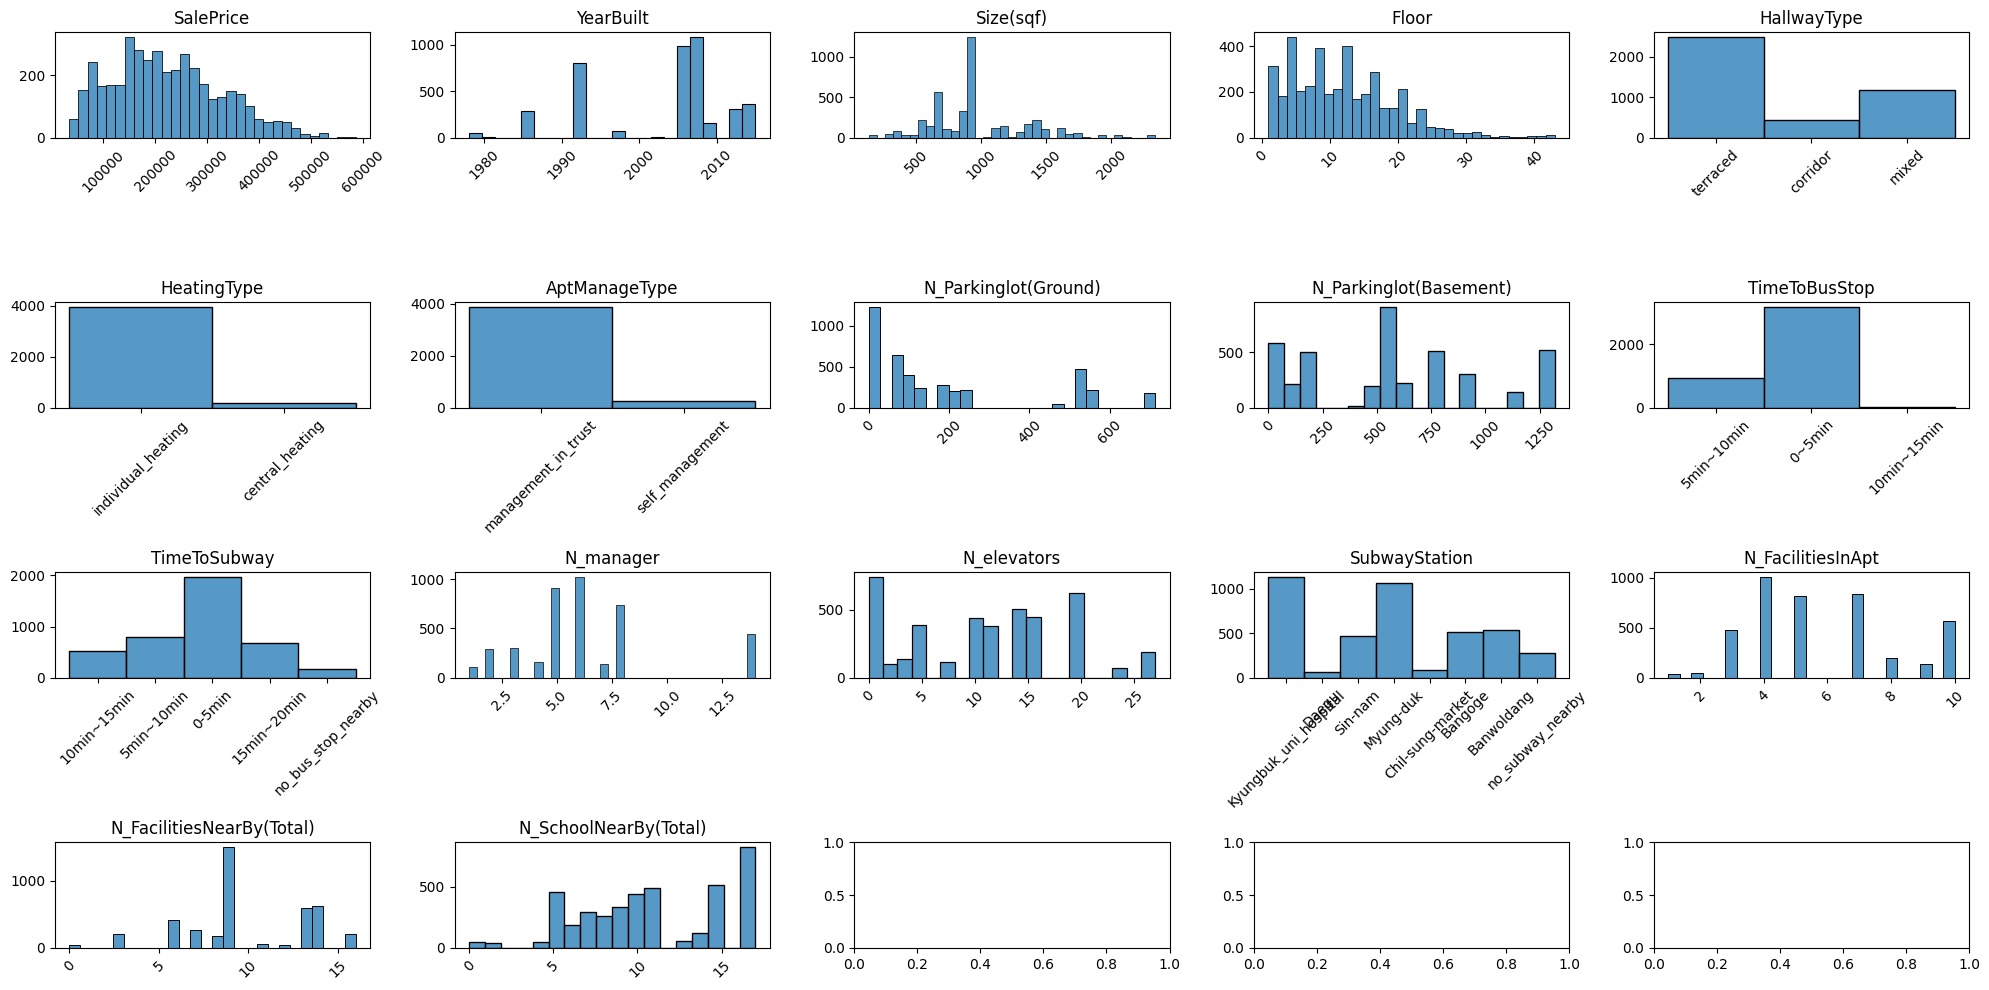

In [3]:
fig, ax = plt.subplots(4, 5, figsize=(20, 10))
for i in range(4):
    for j in range(5):
        if i*5+j > 16:
            break
        sns.histplot(data.iloc[:, i*5+j], ax=ax[i, j])
        ax[i, j].set_title(data.columns[i*5+j])
        ax[i, j].set_xlabel('')
        ax[i, j].set_ylabel('')
        for tick in ax[i, j].get_xticklabels():
            tick.set_rotation(45)
plt.tight_layout()
plt.show()

# Bazowe podejście

## Przetwarzanie danych

In [4]:
from data_functions import get_dummies, output_to_labels

In [5]:
data = output_to_labels(data, "SalePrice")
display(data)

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),SalePrice
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,1
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,2
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0,2
4120,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0,1
4121,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0,2
4122,1978,1327,1,corridor,individual_heating,self_management,87.0,0.0,0~5min,0-5min,1.0,4.0,Kyungbuk_uni_hospital,3,7.0,11.0,1


In [6]:
categories = data.select_dtypes(include="object").columns
print(categories)
data = get_dummies(data, categories)

display(data)

Index(['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop',
       'TimeToSubway', 'SubwayStation'],
      dtype='object')


,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),N_manager,N_elevators,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),...,TimeToSubway_5min~10min,TimeToSubway_no_bus_stop_nearby,SubwayStation_Bangoge,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby
0,2006,814,3,111.0,184.0,3.0,0.0,5,6.0,9.0,...,False,False,False,False,False,False,True,False,False,False
1,1985,587,8,80.0,76.0,2.0,2.0,3,12.0,4.0,...,True,False,False,False,False,True,False,False,False,False
2,1985,587,6,80.0,76.0,2.0,2.0,3,12.0,4.0,...,True,False,False,False,False,True,False,False,False,False
3,2006,2056,8,249.0,536.0,5.0,11.0,5,3.0,7.0,...,False,False,False,False,False,False,False,False,True,False
4,1992,644,2,142.0,79.0,4.0,8.0,3,9.0,14.0,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,2007,1928,24,0.0,1270.0,14.0,16.0,10,9.0,10.0,...,False,False,False,False,False,False,True,False,False,False
4120,2015,644,22,102.0,400.0,5.0,10.0,7,7.0,11.0,...,True,False,False,False,False,True,False,False,False,False
4121,2007,868,20,0.0,1270.0,14.0,16.0,10,9.0,10.0,...,False,False,False,False,False,False,True,False,False,False
4122,1978,1327,1,87.0,0.0,1.0,4.0,3,7.0,11.0,...,False,False,False,False,False,False,True,False,False,False


## Trenowanie modelu

In [7]:
from data_functions import train_valid_split, data_to_dataset
from helper_functions import train_model, get_mse, get_accuracy
from models import Net

In [8]:
train, valid = train_valid_split(data)
train = data_to_dataset(train, target="SalePrice")
valid = data_to_dataset(valid, target="SalePrice")
display(train.tensors[0].shape, valid.tensors[0].shape)

torch.Size([3299, 33])

torch.Size([825, 33])

In [9]:
net = Net(train.tensors[0].shape[1], 100, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [10]:
train_m = True
if train_m:
    iters_list, loss_list, train_eval_list, valid_eval_list = train_model(net, train, valid, criterion, optimizer, get_accuracy)
else:
    state_dict = torch.load("starting_model.tar")
    net.load_state_dict(state_dict)

100%|██████████| 1000/1000 [00:34<00:00, 29.26it/s]


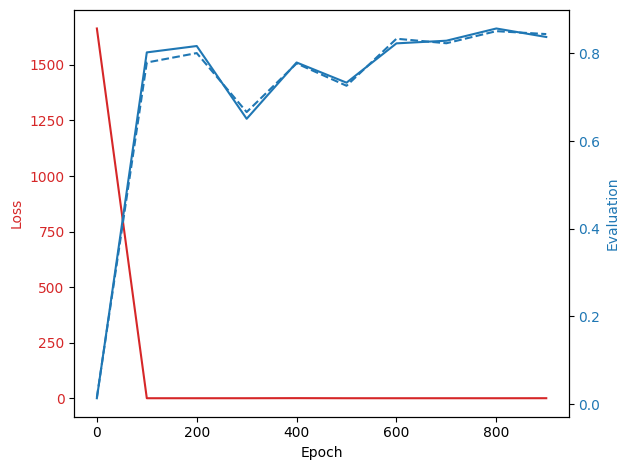

In [11]:
plot_training(iters_list, loss_list, train_eval_list, valid_eval_list)

## Ewaluacja modelu

In [12]:
final_acc = get_accuracy(net, valid)
final_mse = get_mse(net, valid)
print(final_acc)
print(final_mse)

0.8787878787878788
0.4973161220550537


In [14]:
torch.save(net.state_dict(), "starting_model.tar")

- Model słabo sobie radzi z ostatnią klasą
- Trzeba bardziej rozbudować model

# Normalizacja danych 

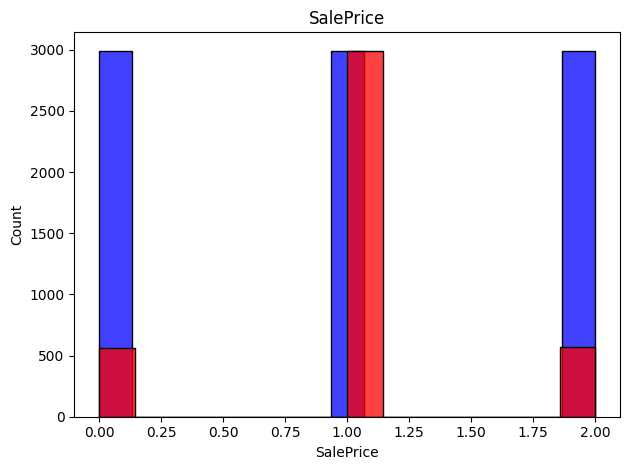

In [13]:
from data_functions import equalize_classes

data_eq = equalize_classes(data, "SalePrice")

fig, ax = plt.subplots()
sns.histplot(data_eq["SalePrice"], ax=ax, label="equalized", color="blue")
sns.histplot(data["SalePrice"], ax=ax, color="red", label="original")
ax.set_title("SalePrice")
plt.tight_layout()
plt.show()

In [14]:
train_eq, valid_eq = train_valid_split(data_eq)

train_eq = data_to_dataset(train_eq, target="SalePrice")
valid_eq = data_to_dataset(valid_eq, target="SalePrice")
display(train_eq.tensors[0], valid_eq.tensors[0])

tensor([[2.0070e+03, 1.6430e+03, 1.4000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0070e+03, 1.6900e+03, 2.5000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9860e+03, 5.0800e+02, 5.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00],
        ...,
        [1.9920e+03, 3.5500e+02, 8.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9920e+03, 6.4000e+02, 1.3000e+01,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9930e+03, 1.7610e+03, 1.7000e+01,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00]])

tensor([[1.9850e+03, 5.8700e+02, 6.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.9930e+03, 6.4400e+02, 1.0000e+01,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0070e+03, 8.6800e+02, 3.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [2.0070e+03, 1.6430e+03, 4.2000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0070e+03, 1.3660e+03, 7.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0070e+03, 1.9280e+03, 2.8000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [26]:
net_eq = Net(train_eq.tensors[0].shape[1], 100, 1)
optimizer = optim.Adam(net_eq.parameters(), lr=0.001)
iter_list, loss_list, train_eval_list, valid_eval_list = train_model(net_eq, train_eq, valid_eq, criterion, optimizer, get_accuracy)

100%|██████████| 1000/1000 [01:14<00:00, 13.34it/s]


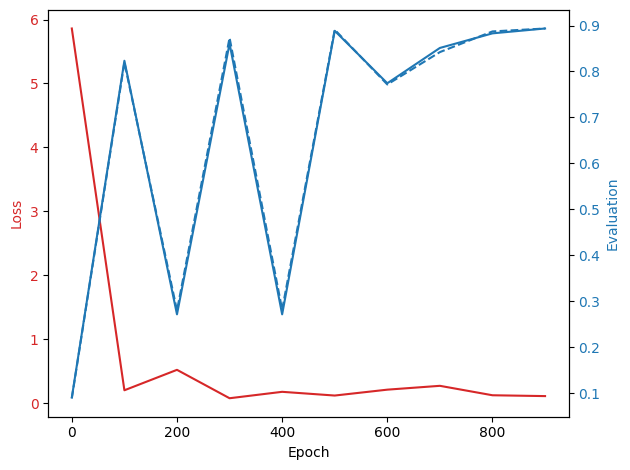

In [27]:
plot_training(iters_list, loss_list, train_eval_list, valid_eval_list)

In [36]:
eval_acc = get_accuracy(net_eq, valid_eq)
eval_mse = get_mse(net_eq, valid_eq)
print(eval_acc)
print(eval_mse)

0.7632311977715878
1.3588759899139404


## Struktury modeli

### Struktury warstw

In [ ]:
layer_values = [25, 50, 100] 
num_layers = [2, 3, 4, 5, 6]

### Batch norm

In [28]:
from models import NetBatchNorm

batch_norm_net = NetBatchNorm(train.tensors[0].shape[1], 100, 1)

In [29]:
iters_list, loss_list, train_eval_list, valid_eval_list = train_model(batch_norm_net, train, valid, criterion, optimizer, get_accuracy)

100%|██████████| 1000/1000 [00:31<00:00, 31.43it/s]


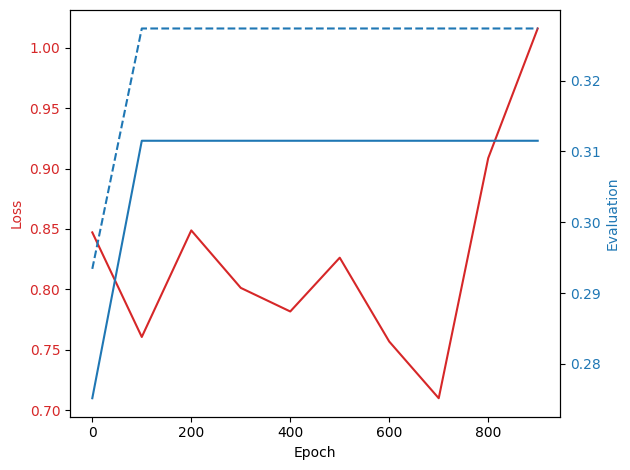

In [30]:
plot_training(iters_list, loss_list, train_eval_list, valid_eval_list)

### Dropout

In [31]:
from models import NetDropout

dropout_net = NetDropout(train.tensors[0].shape[1], 100, 1)

In [32]:
iters_list, loss_list, train_eval_list, valid_eval_list = train_model(dropout_net, train, valid, criterion, optimizer, get_accuracy)

100%|██████████| 1000/1000 [00:30<00:00, 32.63it/s]


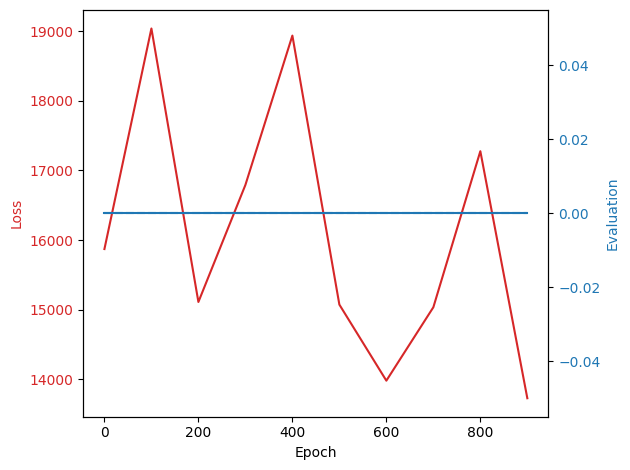

In [33]:
plot_training(iters_list, loss_list, train_eval_list, valid_eval_list)